In [415]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

In [416]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set()

# CUSTOM LAYERS

In [417]:
class InputLayer(tf.keras.layers.Layer):
  def __init__(self, name):
    super(InputLayer, self).__init__(name=name)
    self.a = tf.Variable(initial_value=tf.zeros(shape=[14,2]), trainable=False, name= self.name + "_activation")
    
  def call(self, inputs):
    a1a1 = tf.reshape(inputs[0],shape=(1,1)) #1
    a1a2 = tf.reshape(inputs[1],shape=(1,1)) #2 
    a1a2a2 = tf.reshape(inputs[2],shape=(1,1)) #3
    a1a2a1 = tf.reshape(inputs[3],shape=(1,1)) #4
    a2a2 = tf.reshape(inputs[4],shape=(1,1)) #5
    a2a1 = tf.reshape(inputs[5],shape=(1,1)) #6
    a2a1a1 = tf.reshape(inputs[6],shape=(1,1)) #7
    a2a1a2 = tf.reshape(inputs[7],shape=(1,1)) #8

    to_hidden = []
    to_hidden.append((tf.concat([a1a2a2, a2a2], axis = 1))) #["TrRi"] [3,5]
    to_hidden.append((tf.concat([a1a2a1, a2a1], axis = 1))) #["RiTr"] [4,6] 
    to_hidden.append((tf.concat([a1a1, a2a1], axis = 1))) #["Plu"] [1,6] 
    to_hidden.append((tf.concat([a1a2, a1a2a2], axis = 1))) #["TTra"] [2,3] 
    to_hidden.append((tf.concat([a2a1, a2a1a1], axis = 1))) #["TTrb"] [6,7] 
    to_hidden.append((tf.concat([a1a2, a2a1], axis = 1))) #["Tr"] [2,6]
    to_hidden.append((tf.concat([a1a2a1, a2a1a2], axis = 1))) #["MeTr"] [4,8] 
    to_hidden.append((tf.concat([a1a2a1, a1a2], axis = 1))) #["MoTr"] [4,2] 
    to_hidden.append((tf.concat([a1a1, a1a2a1], axis = 1))) #["RiRi"] [1,4] 
    to_hidden.append((tf.concat([a1a1, a1a2], axis = 1))) #["MoFo"] [1,2] 
    to_hidden.append((tf.concat([a1a2a2, a1a2a1], axis = 1))) #["MMof"] [3,4] 
    to_hidden.append((tf.concat([a1a1, a1a2a2], axis = 1))) #["MoRi"] [1,3] 
    to_hidden.append((tf.concat([a1a2a2, a2a1a1], axis = 1))) #["MeRi"] [3,7] 
    to_hidden.append((tf.concat([a1a1, a2a2], axis = 1))) #["Ri"] [1,5] 

    output = tf.concat(to_hidden,axis = 0)
    self.a.assign(output)
    return self.a.value()

In [418]:
class Layer(tf.keras.layers.Layer):
  def __init__(self, name, weights_init_val, bias_init_val):
    super(Layer, self).__init__(name = name)
    self.units = 14
    self.weights_init_val = weights_init_val
    self.bias_init_val = bias_init_val
    if self.name in ["HiddenLayer"]:
      self.type = "Hidden"
    elif self.name in ["OutputLayer"]:
      self.type = "Output"

  def build(self, input_shape):
    shape = [int(input_shape[-1]),self.units]
    self.w = self.add_weight(initializer = tf.initializers.Constant(self.weights_init_val) ,
                              shape= shape,
                              name = self.name + "_weights")
    self.b = self.add_weight(initializer = tf.initializers.Constant(self.bias_init_val) ,
                              shape= [1, self.units],
                              name = self.name + "_biases")

    self.deltaA = tf.Variable(initial_value=tf.zeros(shape = [1, self.units]),trainable=False, name= self.name + "_adjustements")
    self.a = tf.Variable(initial_value=tf.zeros(shape = [1, self.units]),trainable=False, name= self.name + "_activation")

  def call(self, inputs, temperature):
    
    if self.type == "Hidden":
      net = tf.matmul(inputs, self.w)[:,0]
    elif self.type == "Output":
      net = tf.matmul(inputs, self.w)
      
    self.a.assign(1/(1 + tf.exp((net + self.b)/temperature)))
    return self.a.value()


### Testing foward pass

In [419]:
x = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
x

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32)>

In [420]:
input_layer = InputLayer(name = "InputLayer")
input_layer

In [421]:
res_input = input_layer(x)
res_input

<tf.Tensor: shape=(14, 2), dtype=float32, numpy=
array([[3., 5.],
       [4., 6.],
       [1., 6.],
       [2., 3.],
       [6., 7.],
       [2., 6.],
       [4., 8.],
       [4., 2.],
       [1., 4.],
       [1., 2.],
       [3., 4.],
       [1., 3.],
       [3., 7.],
       [1., 5.]], dtype=float32)>

In [422]:
input_layer.a

<tf.Variable 'InputLayer_activation:0' shape=(14, 2) dtype=float32, numpy=
array([[3., 5.],
       [4., 6.],
       [1., 6.],
       [2., 3.],
       [6., 7.],
       [2., 6.],
       [4., 8.],
       [4., 2.],
       [1., 4.],
       [1., 2.],
       [3., 4.],
       [1., 3.],
       [3., 7.],
       [1., 5.]], dtype=float32)>

In [423]:
hidden_layer = Layer(name = "HiddenLayer",weights_init_val=0.5, bias_init_val=0.0)
hidden_layer

In [424]:
res_hidden = hidden_layer(inputs = res_input, temperature = 1)
res_hidden

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[0.01798621, 0.00669285, 0.02931223, 0.07585818, 0.00150118,
        0.01798621, 0.00247262, 0.04742587, 0.07585818, 0.18242553,
        0.02931223, 0.11920292, 0.00669285, 0.04742587]], dtype=float32)>

In [425]:
hidden_layer.w

<tf.Variable 'HiddenLayer/HiddenLayer_weights:0' shape=(2, 14) dtype=float32, numpy=
array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5]], dtype=float32)>

In [426]:
hidden_layer.a

<tf.Variable 'HiddenLayer/HiddenLayer_activation:0' shape=(1, 14) dtype=float32, numpy=
array([[0.01798621, 0.00669285, 0.02931223, 0.07585818, 0.00150118,
        0.01798621, 0.00247262, 0.04742587, 0.07585818, 0.18242553,
        0.02931223, 0.11920292, 0.00669285, 0.04742587]], dtype=float32)>

In [427]:
output_layer = Layer(name = "OutputLayer",weights_init_val=0.59, bias_init_val=0.0)
output_layer

In [428]:
res_output = output_layer(inputs = res_hidden, temperature = 1)
res_output

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[0.40384   , 0.40384   , 0.40384   , 0.40384   , 0.40384   ,
        0.40384   , 0.40384   , 0.40384   , 0.40384004, 0.40384004,
        0.40384004, 0.40384004, 0.40384004, 0.40384004]], dtype=float32)>

In [429]:
output_layer.w

<tf.Variable 'OutputLayer/OutputLayer_weights:0' shape=(14, 14) dtype=float32, numpy=
array([[0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59,
        0.59, 0.59, 0.59],
     

In [430]:
output_layer.a

<tf.Variable 'OutputLayer/OutputLayer_activation:0' shape=(1, 14) dtype=float32, numpy=
array([[0.40384   , 0.40384   , 0.40384   , 0.40384   , 0.40384   ,
        0.40384   , 0.40384   , 0.40384   , 0.40384004, 0.40384004,
        0.40384004, 0.40384004, 0.40384004, 0.40384004]], dtype=float32)>

In [431]:
error = tf.math.reduce_sum(tf.math.square(res_hidden - res_output))
error

<tf.Tensor: shape=(), dtype=float32, numpy=1.8159815>

### Test back propagation

In [432]:
alpha = 1

In [433]:
delta_Ao = res_output * (res_hidden - res_output) * (1 - res_output) + output_layer.deltaA * (res_hidden - res_output)
delta_Ao

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[-0.09289556, -0.09561447, -0.09016878, -0.0789627 , -0.09686439,
        -0.09289556, -0.09663051, -0.08580787, -0.0789627 , -0.05330626,
        -0.09016878, -0.06852731, -0.09561447, -0.08580787]],
      dtype=float32)>

In [434]:
res_hidden

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[0.01798621, 0.00669285, 0.02931223, 0.07585818, 0.00150118,
        0.01798621, 0.00247262, 0.04742587, 0.07585818, 0.18242553,
        0.02931223, 0.11920292, 0.00669285, 0.04742587]], dtype=float32)>

In [435]:
delta_Wo = alpha * tf.matmul(tf.transpose(res_hidden),delta_Ao)   #dubbio scambiare righe e colonne
delta_Wo

<tf.Tensor: shape=(14, 14), dtype=float32, numpy=
array([[-1.67083903e-03, -1.71974197e-03, -1.62179465e-03,
        -1.42023969e-03, -1.74222316e-03, -1.67083903e-03,
        -1.73801661e-03, -1.54335832e-03, -1.42023969e-03,
        -9.58777615e-04, -1.62179465e-03, -1.23254664e-03,
        -1.71974197e-03, -1.54335832e-03],
       [-6.21736166e-04, -6.39933394e-04, -6.03486202e-04,
        -5.28485572e-04, -6.48298883e-04, -6.21736166e-04,
        -6.46733562e-04, -5.74299251e-04, -5.28485572e-04,
        -3.56770877e-04, -6.03486202e-04, -4.58643073e-04,
        -6.39933394e-04, -5.74299251e-04],
       [-2.72297603e-03, -2.80267349e-03, -2.64304806e-03,
        -2.31457292e-03, -2.83931126e-03, -2.72297603e-03,
        -2.83245579e-03, -2.51522008e-03, -2.31457292e-03,
        -1.56252552e-03, -2.64304806e-03, -2.00868840e-03,
        -2.80267349e-03, -2.51522008e-03],
       [-7.04688765e-03, -7.25313928e-03, -6.84003951e-03,
        -5.98996645e-03, -7.34795583e-03, -7.04688765e

In [436]:
output_layer.w.assign_add(delta_Wo)
output_layer.w

<tf.Variable 'OutputLayer/OutputLayer_weights:0' shape=(14, 14) dtype=float32, numpy=
array([[0.58832914, 0.58828026, 0.5883782 , 0.5885797 , 0.58825773,
        0.58832914, 0.58826196, 0.58845663, 0.5885797 , 0.5890412 ,
        0.5883782 , 0.5887674 , 0.58828026, 0.58845663],
       [0.58937824, 0.58936006, 0.5893965 , 0.58947146, 0.58935165,
        0.58937824, 0.58935326, 0.5894257 , 0.58947146, 0.5896432 ,
        0.5893965 , 0.5895413 , 0.58936006, 0.5894257 ],
       [0.587277  , 0.5871973 , 0.5873569 , 0.5876854 , 0.58716065,
        0.587277  , 0.5871675 , 0.5874848 , 0.5876854 , 0.58843744,
        0.5873569 , 0.5879913 , 0.5871973 , 0.5874848 ],
       [0.5829531 , 0.58274686, 0.5831599 , 0.58401   , 0.58265203,
        0.5829531 , 0.58266973, 0.5834907 , 0.58401   , 0.5859563 ,
        0.5831599 , 0.5848016 , 0.58274686, 0.5834907 ],
       [0.5898605 , 0.58985645, 0.5898646 , 0.5898814 , 0.58985454,
        0.5898605 , 0.5898549 , 0.58987117, 0.5898814 , 0.5899199 ,
      

In [437]:
delta_Ah = res_hidden * (1 - res_hidden) * (tf.matmul(delta_Ao , output_layer.w)) # dubbio scambiare righe per colonne
delta_Ah

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[-0.01244915, -0.00468486, -0.0200582 , -0.04945816, -0.0010562 ,
        -0.01244915, -0.00173802, -0.03185719, -0.04945816, -0.10540765,
        -0.0200582 , -0.07412587, -0.00468486, -0.03185719]],
      dtype=float32)>

In [438]:
delta_Wh = tf.transpose(alpha * tf.transpose(delta_Ah) * res_input)
delta_Wh

<tf.Tensor: shape=(2, 14), dtype=float32, numpy=
array([[-0.03734745, -0.01873942, -0.0200582 , -0.09891631, -0.00633719,
        -0.0248983 , -0.00695207, -0.12742876, -0.04945816, -0.10540765,
        -0.0601746 , -0.07412587, -0.01405457, -0.03185719],
       [-0.06224575, -0.02810913, -0.1203492 , -0.14837447, -0.00739339,
        -0.07469489, -0.01390414, -0.06371438, -0.19783263, -0.2108153 ,
        -0.0802328 , -0.22237761, -0.03279399, -0.15928595]],
      dtype=float32)>

In [439]:
hidden_layer.w.assign_add(delta_Wh)
hidden_layer.w

<tf.Variable 'HiddenLayer/HiddenLayer_weights:0' shape=(2, 14) dtype=float32, numpy=
array([[0.46265256, 0.48126057, 0.4799418 , 0.40108368, 0.4936628 ,
        0.4751017 , 0.49304792, 0.37257123, 0.45054185, 0.39459234,
        0.43982542, 0.4258741 , 0.48594543, 0.4681428 ],
       [0.43775424, 0.47189087, 0.3796508 , 0.35162553, 0.4926066 ,
        0.4253051 , 0.48609588, 0.43628561, 0.30216736, 0.2891847 ,
        0.4197672 , 0.2776224 , 0.467206  , 0.34071404]], dtype=float32)>

---

# CUSTOM MODEL

In [440]:
class MQSelfReflexiveNetwork(tf.keras.Model):
  def __init__(self, learning_rate):
    super(MQSelfReflexiveNetwork, self).__init__(name='MQSelfReflexiveNetwork')

    self.input_layer = InputLayer(name = "InputLayer")
    self.h = Layer(name = "HiddenLayer",weights_init_val=0.5, bias_init_val=0.2)
    self.o = Layer(name = "OutputLayer",weights_init_val=0.59, bias_init_val=0.2)
    self.temperature = tf.Variable(initial_value=1.0,trainable=False, name = "Temperature")
    self.error = tf.Variable(initial_value=0.0,trainable=False, name = "Error")
    self.alpha = learning_rate

  def call(self, input):
    ### FOWARD PASS
    res_input = self.input_layer(input)
    res_hidden = self.h(res_input, self.temperature)
    res_output = self.o(res_hidden, self.temperature)
    return tf.math.reduce_sum(tf.math.square(res_hidden - res_output))
  
  def train_step(self, input):
    ### CALL FOWARD PASS
    self.error.assign(self(input, training = True))

    ### BACK PROPAGATION
    # Compute temperature
    self.temperature.assign(1 - (1 / (1 + self.error) ))
    print(self.temperature)

    # Update outputs weights
    delta_Ao = self.o.a * (self.h.a - self.o.a) * (1 - self.o.a) + (self.o.deltaA * ((self.h.a - self.o.a)) )
    delta_Wo = self.alpha * tf.matmul(tf.transpose(self.h.a),delta_Ao)
    self.o.deltaA.assign(delta_Ao)
    self.o.w.assign_add(delta_Wo)


    ## Update hidden weights
    delta_Ah = self.h.a * (1 - self.h.a) * (tf.matmul(self.o.deltaA , self.o.w))
    delta_Wh = tf.transpose(self.alpha * tf.transpose(delta_Ah) * self.input_layer.a)
    self.h.deltaA.assign(delta_Ah)
    self.h.w.assign_add(delta_Wh)

    return {
        "Error": tf.squeeze(self.error.value()),
        "Temperature": tf.squeeze(self.temperature.value()),
        "Hidden weights": tf.squeeze(self.h.w.value()),
        "Output weights": tf.squeeze(self.o.w.value())
        }

In [441]:
# Construct an instance of CustomModel
input = tf.constant([0.01, 0.00, 0.03, 0.224, 0.875, 0.266, 0.427, 0.168])
model = MQSelfReflexiveNetwork(learning_rate=10)

In [443]:
model.compile()
model_history = model.fit(x = input, epochs=250)

Epoch 1/250
<tf.Variable 'Temperature:0' shape=() dtype=float32>
<tf.Variable 'Temperature:0' shape=() dtype=float32>
1/1 [==============================] - 0s 265ms/step - Error: 1.6763 - Temperature: 0.6263 - Hidden weights: 0.5697 - Output weights: 0.6336
Epoch 2/250
1/1 [==============================] - 0s 2ms/step - Error: 1.3542 - Temperature: 0.5752 - Hidden weights: 0.5994 - Output weights: 0.6527
Epoch 3/250
1/1 [==============================] - 0s 2ms/step - Error: 1.1675 - Temperature: 0.5386 - Hidden weights: 0.6185 - Output weights: 0.6636
Epoch 4/250
1/1 [==============================] - 0s 6ms/step - Error: 1.2477 - Temperature: 0.5551 - Hidden weights: 0.6285 - Output weights: 0.6705
Epoch 5/250
1/1 [==============================] - 0s 3ms/step - Error: 1.4160 - Temperature: 0.5861 - Hidden weights: 0.6353 - Output weights: 0.6762
Epoch 6/250
1/1 [==============================] - 0s 3ms/step - Error: 1.2343 - Temperature: 0.5524 - Hidden weights: 0.6463 - Output we

In [444]:
df_model_history = pd.DataFrame(model_history.history)
df_model_history

,Error,Temperature,Hidden weights,Output weights
0,1.676263,0.626345,"[[0.54139197, 0.50736964, 0.6850412, 0.5554788...","[[0.6384454, 0.6380777, 0.6253419, 0.639119, 0..."
1,1.354224,0.575232,"[[0.5427332, 0.5432738, 0.7089122, 0.5554788, ...","[[0.6679736, 0.6520191, 0.6390816, 0.671726, 0..."
2,1.167516,0.538642,"[[0.56460017, 0.5525224, 0.7285968, 0.5562979,...","[[0.6858065, 0.6594693, 0.6454308, 0.69000375,..."
3,1.247665,0.555094,"[[0.56514615, 0.5525224, 0.75588423, 0.5651958...","[[0.6999379, 0.6688414, 0.65023154, 0.70295054..."
4,1.415956,0.586085,"[[0.5807846, 0.55371934, 0.7656028, 0.57091486...","[[0.7060491, 0.6761288, 0.6557904, 0.7080291, ..."
...,...,...,...,...
245,0.000000,0.000000,"[[0.8723535, 0.79739237, 1.0082113, 0.8384563,...","[[0.87876856, 0.840277, 0.8351646, 0.86416227,..."
246,0.000000,0.000000,"[[0.8723535, 0.79739237, 1.0082113, 0.8384563,...","[[0.87876856, 0.840277, 0.8351646, 0.86416227,..."
247,0.000000,0.000000,"[[0.8723535, 0.79739237, 1.0082113, 0.8384563,...","[[0.87876856, 0.840277, 0.8351646, 0.86416227,..."
248,0.000000,0.000000,"[[0.8723535, 0.79739237, 1.0082113, 0.8384563,...","[[0.87876856, 0.840277, 0.8351646, 0.86416227,..."


<AxesSubplot:>

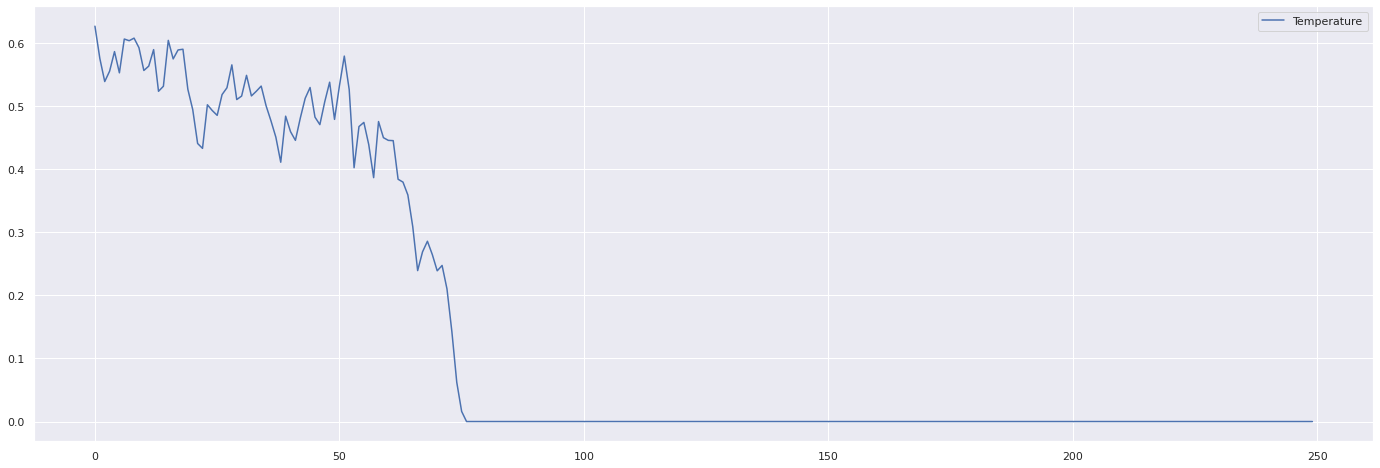

In [445]:
df_model_history[["Temperature"]].plot(figsize=(24,8))

<AxesSubplot:>

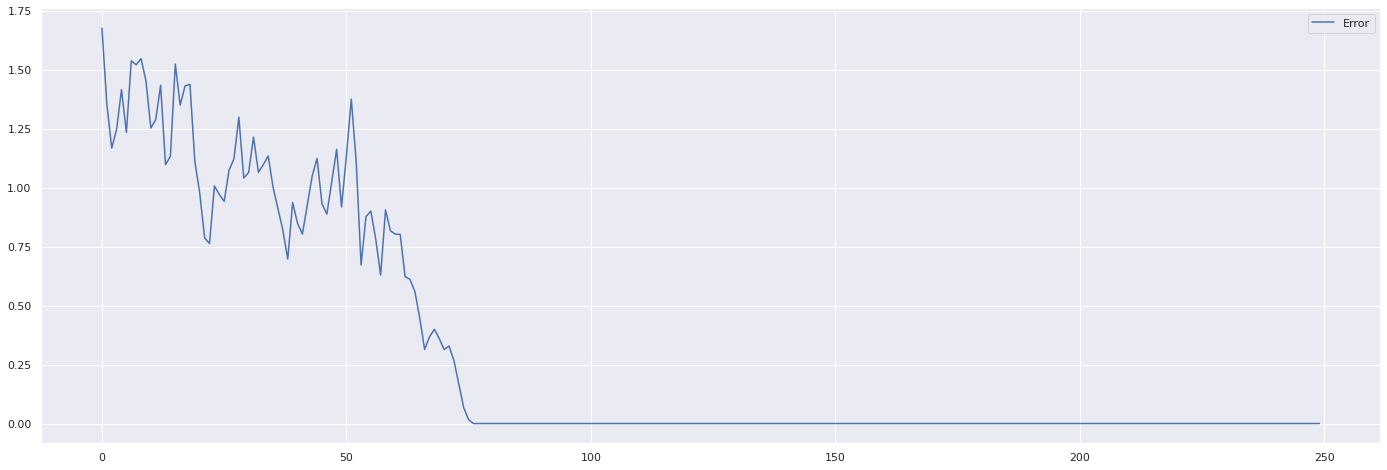

In [446]:
df_model_history[["Error"]].plot(figsize=(24,8))

In [450]:
model.get_weights()[1][0]

array([0.8723535 , 0.79739237, 1.0082113 , 0.8384563 , 0.96061045,
       0.84104544, 0.80876297, 0.8147218 , 1.0411967 , 1.0325518 ,
       0.8804712 , 1.0334905 , 0.8684297 , 1.0359899 ], dtype=float32)

In [451]:
model.get_weights()[1][1]

array([0.85636514, 0.9530692 , 0.9347307 , 0.8806854 , 0.8609639 ,
       0.9698782 , 0.803312  , 0.8450122 , 0.8085204 , 0.8282898 ,
       0.80593926, 0.8759128 , 0.8575403 , 0.86503506], dtype=float32)

In [452]:
abs(model.get_weights()[1][0] - model.get_weights()[1][1])

array([0.01598835, 0.15567684, 0.07348055, 0.04222912, 0.09964657,
       0.12883276, 0.00545096, 0.03029037, 0.23267633, 0.20426196,
       0.07453197, 0.15757775, 0.01088941, 0.17095482], dtype=float32)

In [453]:
#fig = px.line(pd.DataFrame(model_history.history))
#fig.update_layout(title="Monitored variables",
#                   xaxis_title='Epoch',
#                   yaxis_title='',
#                   hovermode='x unified')
#fig.show()

---